In [ ]:
!git clone https: // github.com/Elm-Forest/detr_line
!wget https: // github.com/Elm-Forest/detr_line/releases/download/dataset/coco_powerline.zip
!unzip/content/coco_powerline.zip

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
%cd/content/detr_line

/content/detr_line


### 恢复训练

In [ ]:
!python main.py \
    --epochs 49 \
    --dataset_file coco_powerline \
    --batch_size 8 \
    --num_classes 2 \
    --num_queries 10 \
    --lr 1e-4 \
    --coco_path/content/coco_powerline_1 \
    --output_dir./output \
    --resume/content/drive/MyDrive/checkpoint.pth

### 迁移训练（从0开始）

In [ ]:
!python main.py \
    --epochs 1 \
    --dataset_file coco_powerline \
    --batch_size 8 \
    --num_classes 1 \
    --num_queries 100 \
    --lr 1e-4 \
    --coco_path/content/coco_powerline_1 \
    --output_dir./output \
    --transfer

In [2]:
import torch
from PIL import Image

from models.backbone import Backbone, Joiner
from models.detr import DETR
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from .util.powerline_utils import transform, rescale_bboxes, plot_results

torch.set_grad_enabled(False)
%matplotlib inline

In [3]:
hidden_dim = 256
dropout = 0.1
nheads = 8
dim_feedforward = 2048
enc_layers = 6
dec_layers = 6
pre_norm = False
num_classes = 3
num_queries = 100
aux_loss = False

In [4]:
backbone = Backbone('resnet50', True, False, False)

N_steps = hidden_dim // 2
position_embedding = PositionEmbeddingSine(N_steps, normalize=True)
model = Joiner(backbone, position_embedding)
model.num_channels = backbone.num_channels
backbone = model

In [5]:
transformer = Transformer(
    d_model=hidden_dim,
    dropout=dropout,
    nhead=nheads,
    dim_feedforward=dim_feedforward,
    num_encoder_layers=enc_layers,
    num_decoder_layers=dec_layers,
    normalize_before=pre_norm,
    return_intermediate_dec=True,
)

In [7]:
from models.HT import build_val_CAT_HTIHT

cat_htiht = build_val_CAT_HTIHT(3, 1, inplanes=num_queries, outplanes=num_queries)

In [8]:
model = DETR(
    backbone,
    transformer,
    num_classes=num_classes,
    num_queries=num_queries,
    aux_loss=aux_loss,
    cat_htiht=cat_htiht
)

In [18]:
model.load_state_dict(torch.load(r'./output/checkpoint.pth')['model'])
model.eval();

In [21]:
im = Image.open("../coco_powerline_1/train/04_3420.jpg")
img = transform(im).unsqueeze(0)

In [22]:
outputs = model(img)
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.85
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

torch.Size([1, 2048, 25, 25])


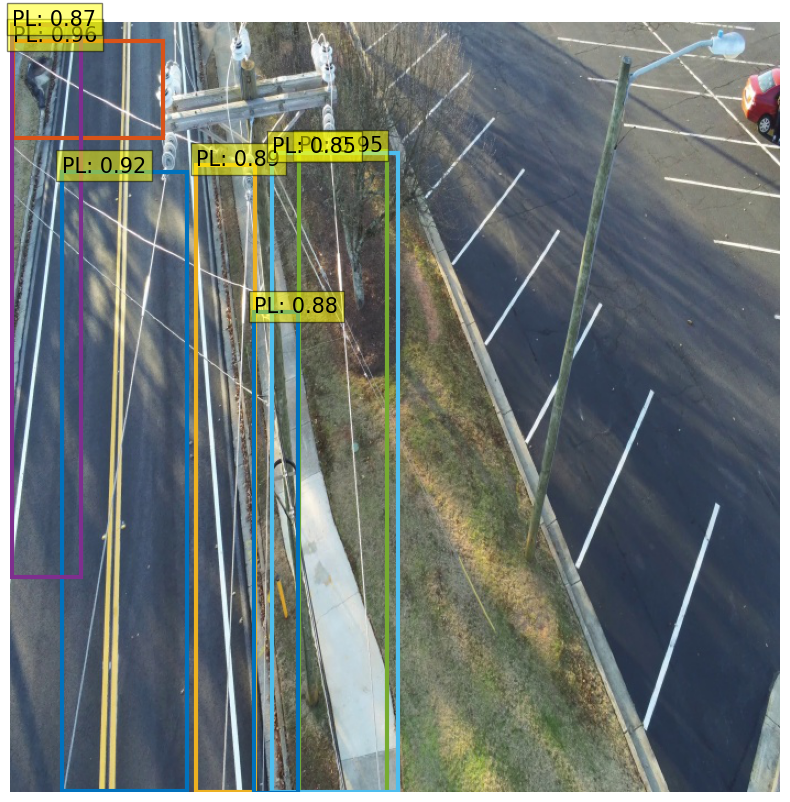

In [23]:
plot_results(im, probas[keep], bboxes_scaled)

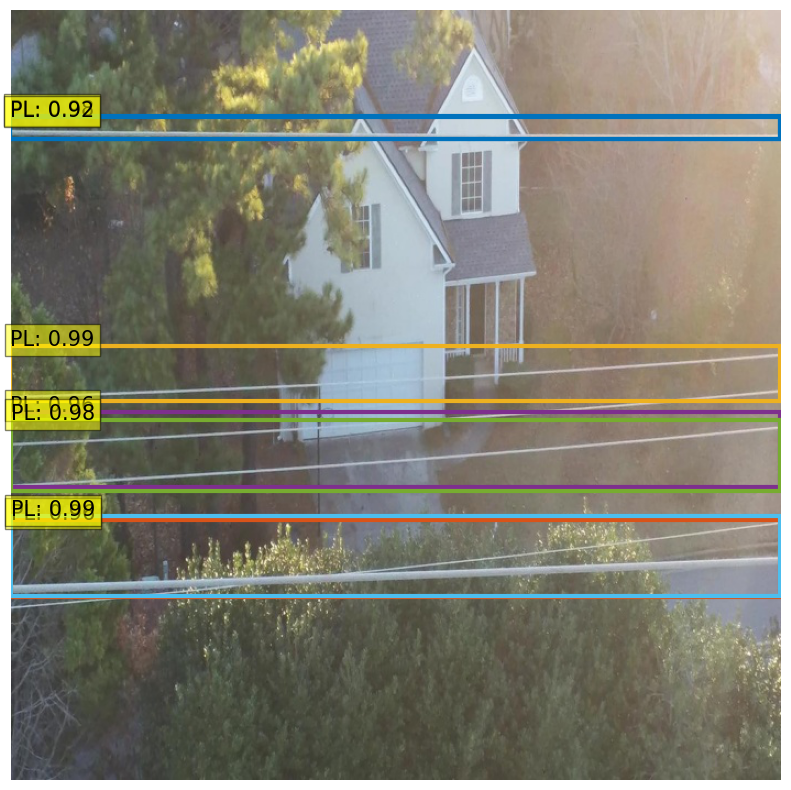

In [16]:
plot_results(im, probas[keep], bboxes_scaled)